Parallel Workflows in langgraph

In [17]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Annotated
from pydantic import BaseModel, Field
from dotenv import load_dotenv
import os
import operator

In [12]:
load_dotenv()
HF_TOKEN  = os.getenv("HF_KEY")

In [13]:
llm = ChatOpenAI(
    model="deepseek-ai/DeepSeek-V3-0324",
    api_key = HF_TOKEN,
    base_url="https://router.huggingface.co/v1",
    temperature=0,
    max_tokens = 500,
)

In [14]:
class Evaluation(BaseModel):
    feedback: str = Field(description="Detailed feedback on the essay aspect")
    score: int = Field(description="Score out of 10 for the essay aspect", ge=0, le=10)
structure_llm = llm.with_structured_output(Evaluation)

In [15]:
essay = """
Artificial Intelligence (AI) and Its Impact on Future Life
(essay body omitted here for brevity)
"""

In [16]:
# Example: single structured evaluation call and print
prompt = f"Evaluate the following essay. Provide detailed feedback and assign a score out of 10.\n\nEssay:\n{essay}"
evaluation = structure_llm.invoke(prompt)
print("Feedback:", evaluation.feedback)
print("Score:", evaluation.score)

Feedback: The essay effectively introduces the topic of Artificial Intelligence (AI) and its potential impact on future life. However, the body of the essay is omitted, which prevents a comprehensive evaluation of the content, arguments, and evidence presented. A complete essay would allow for a better assessment of the coherence, depth of analysis, and relevance of the discussion. Given the limited information, the score reflects only the introductory part.
Score: 5


In [ ]:
class EssayState(TypedDict):
    essay: str
    language_feedback: str
    analysis_feedback: str
    clarity_feedback: str
    overall_feedback: str
    individual_score: Annotated[list, operator.add]
    average_score: float

In [19]:
def evaluate_language(state: EssayState):
    prompt = f"Evaluate the language and writing style of the following essay. Provide feedback and a score out of 10.\n\nEssay:\n{state['essay']}"
    evaluation = structure_llm.invoke(prompt)
  
    return {
        "language_feedback": evaluation.feedback,
        "individual_score": state['individual_score'] + [evaluation.score],
    }

In [20]:
def evaluate_analysis(state: EssayState) -> EssayState:
    prompt = f"Evaluate the depth of analysis and content quality of the following essay. Provide feedback and a score out of 10.\n\nEssay:\n{state['essay']}"
    evaluation = structure_llm.invoke(prompt)
    
    return{
        "analysis_feedback": evaluation.feedback,
        "individual_score": state['individual_score'] + [evaluation.score],
    }

In [21]:
def evaluate_clarity(state: EssayState):
    prompt = f"Evaluate the clarity and coherence of the following essay. Provide feedback and a score out of 10.\n\nEssay:\n{state['essay']}"
    evaluation = structure_llm.invoke(prompt)
    
    return {
        "clarity_feedback": evaluation.feedback,
        "individual_score": state['individual_score'] + [evaluation.score],
    }

In [22]:
def overall_evaluation(state:EssayState):
    prompt = f"Based on the following essay and previous feedback, provide an overall evaluation and suggestions for improvement.\n\nEssay:\n{state['essay']}\n\nLanguage Feedback:\n{state['language_feedback']}\n\nAnalysis Feedback:\n{state['analysis_feedback']}\n\nClarity Feedback:\n{state['clarity_feedback']}"
    evaluation = structure_llm.invoke(prompt)
    average_score = sum(state['individual_score']) / len(state['individual_score'])
    
    return {
        "overall_feedback": evaluation.feedback,
        "average_score": average_score,
    }

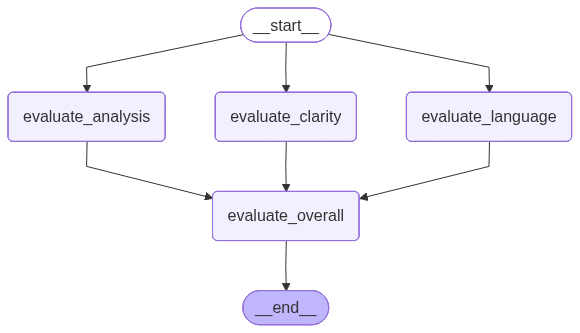

In [25]:
graph = StateGraph(EssayState)
graph.add_node('evaluate_language', evaluate_language)
graph.add_node('evaluate_analysis', evaluate_analysis)
graph.add_node('evaluate_clarity', evaluate_clarity)
graph.add_node('evaluate_overall', overall_evaluation)
# Edges
graph.add_edge(START, 'evaluate_language')
graph.add_edge(START, 'evaluate_analysis')
graph.add_edge(START, 'evaluate_clarity')
graph.add_edge('evaluate_language', 'evaluate_overall')
graph.add_edge('evaluate_analysis', 'evaluate_overall')
graph.add_edge('evaluate_clarity', 'evaluate_overall')
graph.add_edge('evaluate_overall', END)
initial_state = { 'essay': essay}
workflow = graph.compile(initial_state)
workflow

In [26]:
workflow.invoke(initial_state)

ValueError: Checkpointer requires one or more of the following 'configurable' keys: thread_id, checkpoint_ns, checkpoint_id